# Configuration

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import os
import sys
import datetime
import json
import importlib
import models.recursive_reasoning.trm_unimodal as trm_unimodal
importlib.reload(trm_unimodal)
# --- IMPORTS ---
# Ensure these imports match your file structure
# from my_dataset import NuScenesMiniDataset, custom_collate 
from models.recursive_reasoning.trm_unimodal import (
    TRM_ACT_NuScenes,
    TRM_ACT_NuScenes_Config
)

from models.losses import calculate_metrics

# Helper Functions

In [ ]:
# --- 1. LOSS & METRICS UTILS ---

class TrajectoryLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # SmoothL1 is robust to outliers
        self.reg_loss = nn.SmoothL1Loss(reduction='none') 

    def forward(self, pred_traj, target_traj, valid_mask):
        """
        pred_traj: [Batch, Agents, Future, 2]
        target_traj: [Batch, Future, Agents, 7]
        valid_mask: [Batch, Future, Agents]
        """
        # Align Target: [B, T, N, 7] -> [B, N, T, 7]
        target_traj = target_traj.permute(0, 2, 1, 3)
        valid_mask = valid_mask.permute(0, 2, 1) # [B, N, T]

        # Slice (x, y)
        gt_xy = target_traj[..., :2] 

        # Calculate Loss
        loss = self.reg_loss(pred_traj, gt_xy)
        loss = loss.mean(dim=-1) # Mean over (x,y) -> [B, N, T]

        # Apply Mask
        masked_loss = loss * valid_mask
        num_valid = valid_mask.sum() + 1e-6
        
        return masked_loss.sum() / num_valid

In [28]:
# --- 2. LOGGING HELPER ---

class Logger:
    def __init__(self, log_dir, run_name, config_dict):
        os.makedirs(log_dir, exist_ok=True)
        self.log_path = os.path.join(log_dir, f"{run_name}.log")
        
        # Initialize file and write header/config
        with open(self.log_path, 'w') as f:
            f.write(f"=== TRAINING LOG: {run_name} ===\n")
            f.write(f"Date: {datetime.datetime.now()}\n")
            f.write("=== CONFIGURATION ===\n")
            # Pretty print config dictionary
            f.write(json.dumps(config_dict, indent=4, default=str)) 
            f.write("\n=====================\n\n")
            
    def log(self, message):
        print(message) # Print to console
        with open(self.log_path, 'a') as f:
            f.write(message + "\n") # Write to file


# Dataset Loader

In [29]:
'''
Standalone demo of how to use the preprocessed nuscenes data.

Requires standard packages plus:
    pip install nuscenes-devkit torch torchvision
'''
from nuscenes.nuscenes import NuScenes
from pyquaternion import Quaternion
import torch
from torchvision.transforms.functional import to_tensor, to_pil_image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.pyplot as plt
import argparse
from torchvision import transforms # <--- ADDED: Required for ResNet transformations

SAMPLE_FREQ = 2
max_obstacles = 30
n_history = 2*SAMPLE_FREQ # current time inclusive
n_horizon = 6*SAMPLE_FREQ

In [ ]:
def custom_collate(batch):
    'Necessary while LIDAR data list of variable length lists. If LIDAR is converted to BEV, this is no longer necessary'
    collated = {}

    # stack tensor-like things
    collated['obs_pose'] = torch.stack([b['obs_pose'] for b in batch])
    collated['obs_mask'] = torch.stack([b['obs_mask'] for b in batch])
    collated['targets']  = torch.stack([b['targets'] for b in batch])
    collated['org_obs_pose'] = torch.stack([b['org_obs_pose'] for b in batch])
    collated['org_targets']  = torch.stack([b['org_targets'] for b in batch])
    collated['targets_mask']  = torch.stack([b['targets_mask'] for b in batch])
    collated['camera'] = torch.stack([b['camera'] for b in batch])
    collated['idx'] = np.stack([b['idx'] for b in batch])

    # lidar is list of variable-length tensors → DO NOT stack
    collated['lidar'] = [b['lidar'] for b in batch]

    # bev field is not in every dataset
    if 'bev' in batch[0]:
        collated['bev'] = np.stack([b['bev'] for b in batch])

    return collated

class NuScenesDataset(Dataset):
    def __init__(self, data_pth, raw_data_dir, norm_stats=True):
        data = np.load(data_pth, allow_pickle=True)
        self.norm_stats = norm_stats
        self.obs_pose = torch.from_numpy(data['obs_pose']).float()          # (n_examples, n_history, MAX_OBSTACLES, 7)
        self.obs_mask = torch.from_numpy(data['obs_mask'])                  # (n_examples, n_history, MAX_OBSTACLES)
        self.camera_files = data['camera']                                  # filepaths: (n_examples, n_history)
        self.lidar_files = data['lidar']                                    # filepaths: (n_examples, n_history)
        self.targets = torch.from_numpy(data['targets']).float()            # (n_examples, n_horizon, MAX_OBSTACLES, 7)
        self.targets_mask = torch.from_numpy(data['targets_mask'])          # (n_examples, n_horizon, MAX_OBSTACLES)

        self.ego_pose = torch.from_numpy(data['ego_pose']).float()          # (n_examples, n_history, 7)
        self.raw_obs_pose = torch.from_numpy(data['raw_obs_pose']).float()  # (n_examples, n_history, MAX_OBSTACLES, 7)
        self.ego_target = torch.from_numpy(data['ego_target']).float()      # (n_examples, n_horizon, 7)
        self.raw_target = torch.from_numpy(data['raw_target']).float()      # (n_examples, n_horizon, MAX_OBSTACLES, 7)
        self.obs_type = data['obs_type' ]                                   # strings: (n_examples, n_history, MAX_OBSTACLES)

        if 'bev' in data: # necessary for old versions where bev is not in data
            self.bev = data['bev']                                          # None or (n_examples, n_history, 4, 256, 256)
        else:
            self.bev = None

        self.n_samples = self.obs_pose.shape[0]
        self.raw_data_dir = raw_data_dir
        
         # --- IMPORTANT: RESNET-18 PREPROCESSING PIPELINE ---
        # 1. Resize to 256 (preserves aspect ratio)
        # 2. Crop center 224x224
        # 3. Convert to Tensor (0-1 float)
        # 4. Normalize with ImageNet mean/std
        self.resnet_transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def __len__(self):
        return self.n_samples

    def camera_loader(self, path):
        # based on pytorch pil_loader: https://docs.pytorch.org/vision/main/_modules/torchvision/datasets/folder.html#ImageFolder
        assert path.endswith('.jpg'), 'Unsupported filetype {}'.format(file_name)

        full_path = os.path.join(self.raw_data_dir, path)
        with open(full_path, "rb") as f:
            img = Image.open(f).convert("RGB")
        return to_tensor(img)

    def lidar_loader(self, path):
        # based on nuscenes LidarPointCloud loader: https://github.com/nutonomy/nuscenes-devkit/blob/d9de17a73bdc06ce97a02f77ae7edb9b0406e851/python-sdk/nuscenes/utils/data_classes.py#L247
        assert path.endswith('.bin'), 'Unsupported filetype {}'.format(file_name)

        full_path = os.path.join(self.raw_data_dir, path)
        scan = np.fromfile(full_path, dtype=np.float32)
        points = scan.reshape((-1, 5))[:, :4] # keep only x, y, z, intensity
        return torch.from_numpy(points)

    def __getitem__(self, idx):
        # Load history camera / lidar sequences
        camera_seq = torch.stack([self.camera_loader(f) for f in self.camera_files[idx]])
        lidar_seq  = [self.lidar_loader(f).tolist() for f in self.lidar_files[idx]]
        # Normalized versions (xyz only)
        norm_obs_pose = self.normalize_positions(self.obs_pose[idx])
        norm_targets  = self.normalize_positions(self.targets[idx])
        
        sample = {
            'org_obs_pose': self.obs_pose[idx],         # (n_history, MAX_OBSTACLES, 7)
            'obs_mask': self.obs_mask[idx],         # (n_history, MAX_OBSTACLES)
            # normalized versions
            "obs_pose": norm_obs_pose,             # normalized xyz
            "targets": norm_targets,               # normalized xyz
            'camera': camera_seq,                   # list of n_history tensors
            'lidar': lidar_seq,                     # list of n_history tensors
            'org_targets': self.targets[idx],           # (n_horizon, MAX_OBSTACLES, 7)
            'targets_mask': self.targets_mask[idx], # (n_horizon, MAX_OBSTACLES) 
            'idx': idx,                             # scalar
        }
        if self.bev is not None:
            sample['bev'] = self.bev[idx]            # (n_history, 4, 256, 256)
        return sample

    def get_obs_type(self, idx):
        return self.obs_type[idx]           # (n_history, MAX_OBSTACLES)
    
    def get_raw_data(self, idx):
        return {
            'ego_pose':self.ego_pose[idx],              # (n_history, 7)
            'raw_obs_pose':self.raw_obs_pose[idx],      # (n_history, MAX_OBSTACLES, 7)
            'ego_target':self.ego_target[idx],          # (n_horizon, 7)
            'raw_target':self.raw_target[idx],          # (n_horizon, MAX_OBSTACLES, 7)
        }
    

    def compute_normalization_stats(self, max_samples=None):
        """
        Compute mean and std for obstacle positions (x,y,z) and optionally yaw.
        Only uses training data. Uses obs_mask to ignore padded entries.

        max_samples: optionally limit number of samples for speed.
        """
        # Accumulators
        sum_pos = torch.zeros(3)
        sum_pos_sq = torch.zeros(3)
        count = 0

        N = self.n_samples if max_samples is None else min(self.n_samples, max_samples)

        for idx in range(N):
            # (H, K, 7)
            poses = self.obs_pose[idx][..., :3]       # (x,y,z)
            mask  = self.obs_mask[idx]                # (H,K)

            valid = mask.bool().reshape(-1)
            valid_poses = poses.reshape(-1, 3)[valid]

            if valid_poses.numel() == 0:
                continue

            sum_pos += valid_poses.sum(dim=0)
            sum_pos_sq += (valid_poses ** 2).sum(dim=0)
            count += valid_poses.shape[0]

        mean = sum_pos / count
        var  = (sum_pos_sq / count) - (mean ** 2)
        std  = torch.sqrt(var + 1e-8)

        stats = {
            "pos_mean": mean,
            "pos_std": std,
            "count": count,
        }
        return stats
    
    def normalize_positions(self, pos):
        """
        pos: (H, K, 7) or (T, K, 7) — only normalizes :3 (xyz).
        Returns a NEW tensor. Does not modify input.
        """
        if self.norm_stats is None:
            return pos  # No-op if not provided

        mean = self.norm_stats["pos_mean"].to(pos.device)
        std  = self.norm_stats["pos_std"].to(pos.device)

        out = pos.clone()
        out[..., :3] = (out[..., :3] - mean) / std
        return out


In [ ]:
print("Loading Dataset...")
    
split_type = "standard"
train_data_pth = f'/home/vilin/Rapid_Adapt_SM/src/data/{split_type}/train.npz'
val_data_pth = f'/home/vilin/Rapid_Adapt_SM/src/data/{split_type}/val.npz'
test_data_pth = f'/home/vilin/Rapid_Adapt_SM/src/data/{split_type}/test.npz'

raw_data_dir = '/home/vilin/Rapid_Adapt_SM/raw_data/nuscenes'
def check_paths(data_pth):
    # Check if paths exist to avoid crashing
    if not os.path.exists(data_pth):
        print(f"Error: Data path not found: {data_pth}")
        return

check_paths(train_data_pth)
check_paths(val_data_pth)
check_paths(test_data_pth)


Loading Dataset...


In [ ]:
print(f'Loading train dataset...')
tr_dataset = NuScenesDataset(train_data_pth, raw_data_dir)
print('Loaded!')
stats = tr_dataset.compute_normalization_stats()
print(f"Computed normalization stats: {stats}")

tr_dataset = NuScenesDataset(train_data_pth, raw_data_dir, norm_stats=stats)
print('Loaded normalized train dataset!')

print(f'Loading val dataset...')
val_dataset = NuScenesDataset(val_data_pth, raw_data_dir, norm_stats=stats)
print('Loaded!')

print(f'Loading test dataset...')
test_dataset = NuScenesDataset(test_data_pth, raw_data_dir, norm_stats=stats)
print('Loaded!')

Loading train dataset...
Loaded!
Computed normalization stats: {'pos_mean': tensor([ 0.4800, -0.8950,  0.9807]), 'pos_std': tensor([19.9558, 25.0250,  0.8981]), 'count': 1349050}
Loaded normalized train dataset!
Loading val dataset...
Loaded!
Loading test dataset...
Loaded!


In [ ]:
tr_dataloader = DataLoader(tr_dataset, batch_size=16, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, collate_fn=custom_collate)

In [34]:
import matplotlib.pyplot as plt

# plot for only one object in one sample
def plot_trajectories(pred_traj, target_traj, title="Trajectories", filename = "model_default"):
    """
    pred_traj: [Future, 2]
    target_traj: [Future, 7]
    """
    plt.figure(figsize=(8, 8))
    plt.title(title)
    plt.xlabel("X")
    plt.ylabel("Y")
    
    # Plot predicted trajectory
    plt.plot(pred_traj[:, 0].detach().cpu(), pred_traj[:, 1].detach().cpu(), 'ro--', label="Predicted")
    
    # Plot ground truth trajectory
    plt.plot(target_traj[:, 0].detach().cpu(), target_traj[:, 1].detach().cpu(), 'go--', label="Ground Truth")
    
    plt.legend()
    plt.axis('equal')
    plt.grid(True)
    save_path = f'plots/{filename}.png'
   
    os.makedirs("plots", exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Plot saved to: {save_path}")

    #plt.show()

# Training Script

In [46]:
import os
import torch
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

# --- helpers: loss + metrics consistent with your tensor shapes ---

def traj_loss_smooth_l1_from_batch(pred, targets, targets_mask, out_slice=2):
    """
    pred:         [B, A, H, out_dim]   (from model)
    targets:      [B, H, A, 7]
    targets_mask: [B, H, A]            (1 valid, 0 pad)
    """
    # align targets -> [B, A, H, out_slice]
    tgt = targets[..., :out_slice].permute(0, 2, 1, 3).contiguous()
    m = targets_mask.permute(0, 2, 1).to(pred.dtype).contiguous()  # [B, A, H]

    pred_xy = pred[..., :out_slice]
    loss = torch.nn.functional.smooth_l1_loss(pred_xy, tgt, reduction="none").sum(-1)  # [B,A,H]
    return (loss * m).sum() / (m.sum() + 1e-6)


@torch.no_grad()
def compute_ade_fde(pred, targets, targets_mask, out_slice=2):
    """
    Returns scalar ADE/FDE (averaged over valid agents+timesteps).
    """
    tgt = targets[..., :out_slice].permute(0, 2, 1, 3).contiguous()         # [B,A,H,2]
    m = targets_mask.permute(0, 2, 1).to(pred.dtype).contiguous()           # [B,A,H]

    pred_xy = pred[..., :out_slice]
    dist = torch.linalg.norm(pred_xy - tgt, dim=-1)                         # [B,A,H]

    ade = (dist * m).sum() / (m.sum() + 1e-6)

    # FDE: last horizon step only
    dist_last = dist[:, :, -1]
    m_last = m[:, :, -1]
    fde = (dist_last * m_last).sum() / (m_last.sum() + 1e-6)

    return ade.item(), fde.item()


def run_act_steps(model, batch, carry):
    """
    If halt_max_steps==1, this is just one forward.
    If >1, it loops until all sequences halted or max steps hit.
    """
    outputs = None
    for _ in range(model.config.halt_max_steps):
        carry, outputs = model(carry, batch)
        # if training and ACT enabled, you can early stop when all halted
        if carry.halted.all():
            break
    return carry, outputs


def train():
    RUN_NAME = "trm_av_unimodal_experiment_norm_v1"
    LOG_DIR = "logs"
    CKPT_DIR = "checkpoints"
    os.makedirs(f"{CKPT_DIR}/{RUN_NAME}", exist_ok=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # --- Infer key dims from a real batch (prevents config mismatch) ---
    sample = next(iter(tr_dataloader))
    n_history = sample["obs_pose"].shape[1]
    max_obstacles = sample["obs_pose"].shape[2]
    n_horizon = sample["targets"].shape[1]

    # --- Model config (for TRM_ACT_NuScenes) ---
    config_dict = {
        "batch_size": 16,  # used only for some initializations; real batch size can vary
        "n_history": n_history,
        "max_obstacles": max_obstacles,
        "n_horizon": n_horizon,

        "in_dim": 7,
        "out_dim": 2,          # predict x,y
        "out_slice": 2,        # supervise x,y
        "predict_delta": True,

        "global_len": 1,       # keep global latent token
        "seq_len" : max_obstacles * n_history,
        
        "hidden_size": 256,
        "expansion": 2.0,
        "num_heads": 4,
        "H_cycles": 3,
        "L_cycles": 6,
        "H_layers": 0,
        "L_layers": 2,
        "pos_encodings": "none",  # can switch to "rope" later

        "halt_max_steps": 1,        # set >1 if you really want ACT stepping
        "halt_exploration_prob": 0.0,
        "no_ACT_continue": True,

        "forward_dtype": "float32",
        "mlp_t": False,
    }

    # Initialize Logger
    logger = Logger(LOG_DIR, RUN_NAME, config_dict)
    logger.log("Loading Dataset...")
    logger.log(f"Dataset Loaded. Train samples: {len(tr_dataset)}, Val samples: {len(val_dataset)}")

    # --- Model ---
    logger.log("Initializing Model...")
    model = TRM_ACT_NuScenes(config_dict).to(device)

    optimizer = optim.AdamW(model.parameters(), lr=1e-4)

    # --- Training loop ---
    global_step = 0
    for epoch in range(10):
        logger.log(f"\n=== Starting Epoch {epoch+1}/10 ===")
        model.train()

        running_loss = 0.0
        running_ade = 0.0
        running_fde = 0.0
        running_count = 0

        for batch_idx, batch in enumerate(tr_dataloader):
            obs_pose = batch["obs_pose"].to(device)              # [B, Hist, A, 7]
            obs_mask = batch["obs_mask"].to(device)              # [B, Hist, A]
            targets = batch["targets"].to(device)                # [B, Fut, A, 7]
            targets_mask = batch.get("targets_mask", None)
            if targets_mask is None:
                # fallback (but prefer using real targets_mask!)
                targets_mask = (targets[..., :2].abs().sum(dim=-1) > 1e-3).to(obs_pose.dtype)
            else:
                targets_mask = targets_mask.to(device)

            model_input = {
                "obs_pose": obs_pose,
                "obs_mask": obs_mask,
                # NOTE: camera is ignored by TRM_ACT_NuScenes; keep it out unless your model consumes it
                # "camera": batch["camera"].to(device),
            }

            # init carry correctly
            carry = model.initial_carry(model_input)

            # forward (handles halt_max_steps properly)
            carry, outputs = run_act_steps(model, model_input, carry)
            pred = outputs["pred"]  # [B, A, H, out_dim]

            loss = traj_loss_smooth_l1_from_batch(pred, targets, targets_mask, out_slice=config_dict["out_slice"])

            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            global_step += 1
            running_loss += loss.item()

            ade, fde = compute_ade_fde(pred, targets, targets_mask, out_slice=config_dict["out_slice"])
            running_ade += ade
            running_fde += fde
            running_count += 1

            if global_step % 10 == 0:
                logger.log(
                    f"Epoch [{epoch+1}] Step [{global_step}] "
                    f"Loss: {running_loss/running_count:.4f} | "
                    f"ADE: {running_ade/running_count:.4f} | "
                    f"FDE: {running_fde/running_count:.4f}"
                )
                running_loss = running_ade = running_fde = 0.0
                running_count = 0

            if global_step % 100 == 0 or global_step == 1:
                # Plot first sample in batch, first 4 agents
                B, A, H, _ = pred.shape
                for i in range(min(4, A)):
                    pred_xy = pred[0, i, :, :2].detach().cpu()            # [H,2]
                    gt_xy = targets[0, :, i, :2].detach().cpu()           # [H,2] (targets is [B,H,A,7])
                    plot_trajectories(
                        pred_xy,
                        gt_xy,
                        title=f"Agent {i} @ step {global_step}",
                        filename=f"{RUN_NAME}_{global_step}_{i}",
                    )

            if global_step % 500 == 0:
                ckpt_path = os.path.join(CKPT_DIR, RUN_NAME, f"step_{global_step}.pth")
                torch.save(
                    {
                        "model": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "global_step": global_step,
                        "epoch": epoch,
                        "config": config_dict,
                    },
                    ckpt_path,
                )
                logger.log(f"Saved checkpoint to {ckpt_path}")

        # --- Validation ---
        logger.log("Running Validation...")
        model.eval()
        val_ade_sum = 0.0
        val_fde_sum = 0.0
        val_n = 0

        with torch.no_grad():
            for batch in val_dataloader:
                obs_pose = batch["obs_pose"].to(device)
                obs_mask = batch["obs_mask"].to(device)
                targets = batch["targets"].to(device)
                targets_mask = batch.get("targets_mask", None)
                if targets_mask is None:
                    targets_mask = (targets[..., :2].abs().sum(dim=-1) > 1e-3).to(obs_pose.dtype)
                else:
                    targets_mask = targets_mask.to(device)

                model_input = {"obs_pose": obs_pose, "obs_mask": obs_mask}
                carry = model.initial_carry(model_input)

                carry, outputs = run_act_steps(model, model_input, carry)
                pred = outputs["pred"]

                ade, fde = compute_ade_fde(pred, targets, targets_mask, out_slice=config_dict["out_slice"])
                val_ade_sum += ade
                val_fde_sum += fde
                val_n += 1

        logger.log(
            f"Validation Results - Epoch {epoch+1}: "
            f"ADE: {val_ade_sum/max(val_n,1):.4f} | "
            f"FDE: {val_fde_sum/max(val_n,1):.4f}"
        )
        logger.log("-" * 30)

    logger.log("Training Complete.")


In [47]:
import os

# Set this to "1" to force CUDA commands to run synchronously.
# This ensures the error stack trace points to the exact line causing the crash.
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# Optional: Enable Device-Side Assertions (DSA) for better error messages 
# (specifically for index out-of-bounds or assertion failures)
os.environ['TORCH_USE_CUDA_DSA'] = "1"

env: CUDA_LAUNCH_BLOCKING=1
env: TORCH_USE_CUDA_DSA=1
Using device: cuda
Loading Dataset...
Dataset Loaded. Train samples: 14974, Val samples: 3188
Initializing Model...

=== Starting Epoch 1/10 ===
Plot saved to: plots/trm_av_unimodal_experiment_norm_v1_1_0.png
Plot saved to: plots/trm_av_unimodal_experiment_norm_v1_1_1.png
Plot saved to: plots/trm_av_unimodal_experiment_norm_v1_1_2.png
Plot saved to: plots/trm_av_unimodal_experiment_norm_v1_1_3.png
Epoch [1] Step [10] Loss: 0.9011 | ADE: 1.2881 | FDE: 1.6846
Epoch [1] Step [20] Loss: 0.6616 | ADE: 1.0607 | FDE: 1.5083
Epoch [1] Step [30] Loss: 0.4670 | ADE: 0.8343 | FDE: 1.1690
Epoch [1] Step [40] Loss: 0.3640 | ADE: 0.7129 | FDE: 1.1794
Epoch [1] Step [50] Loss: 0.3351 | ADE: 0.6547 | FDE: 1.0761
Epoch [1] Step [60] Loss: 0.3466 | ADE: 0.6812 | FDE: 1.1478
Epoch [1] Step [70] Loss: 0.3109 | ADE: 0.6283 | FDE: 1.0529
Epoch [1] Step [80] Loss: 0.3138 | ADE: 0.6358 | FDE: 1.0686
Epoch [1] Step [90] Loss: 0.3350 | ADE: 0.6505 | FDE: 1.1

KeyboardInterrupt: 

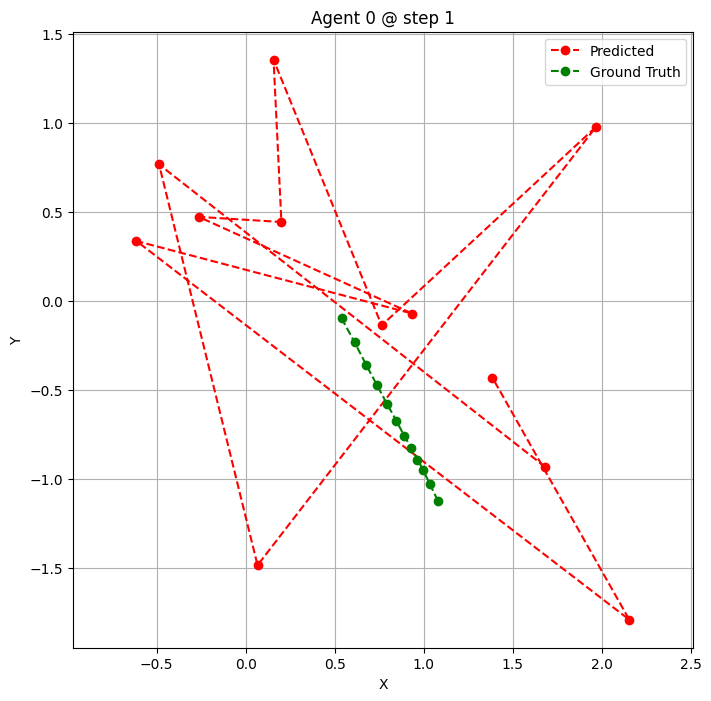

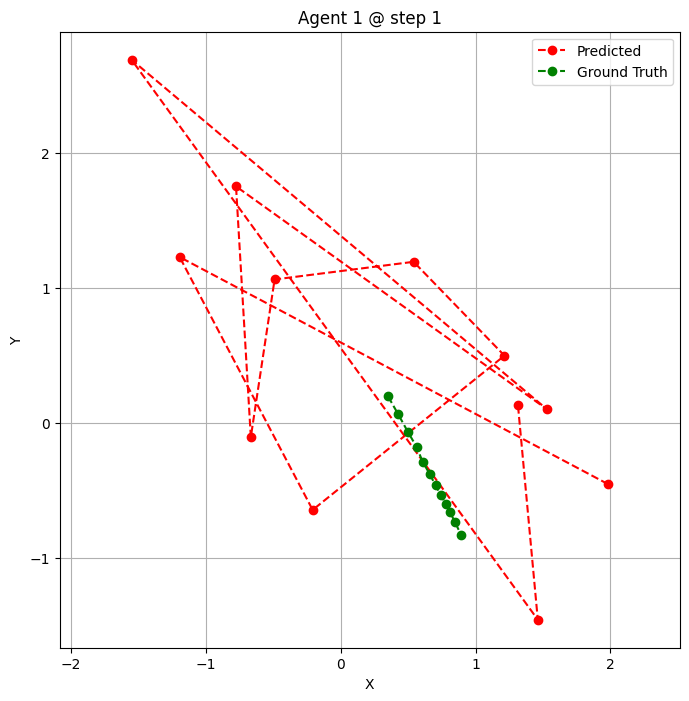

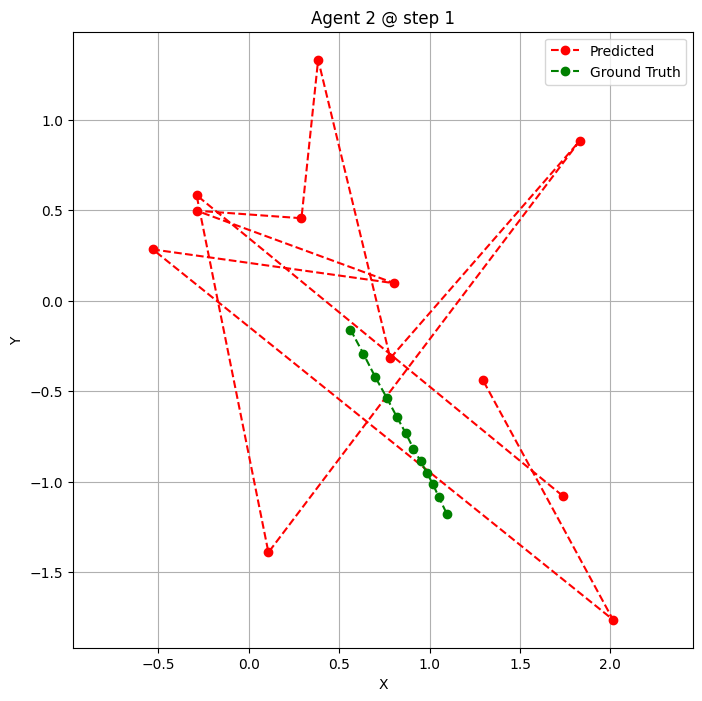

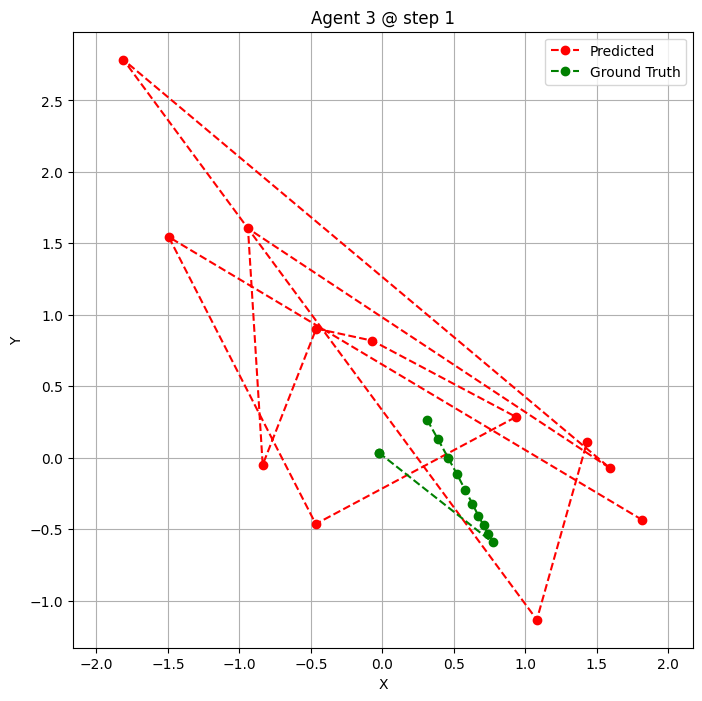

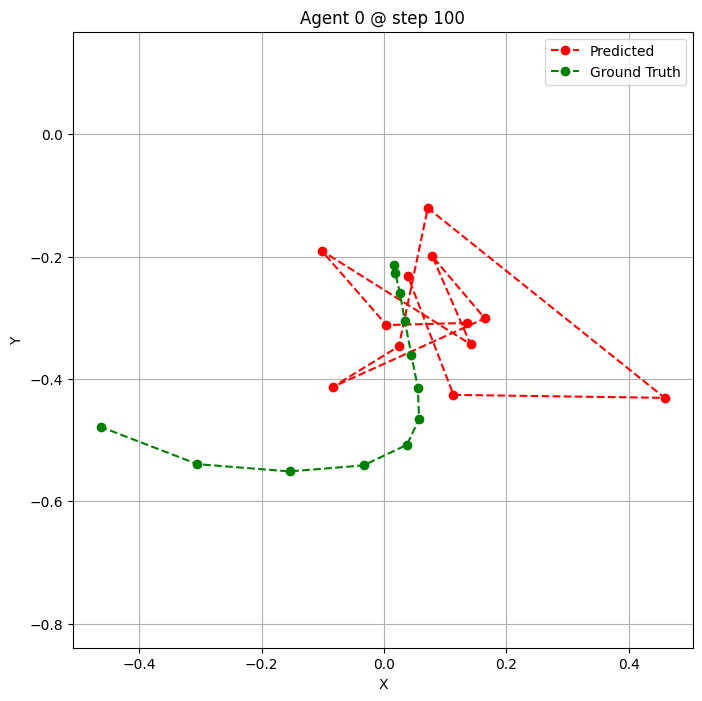

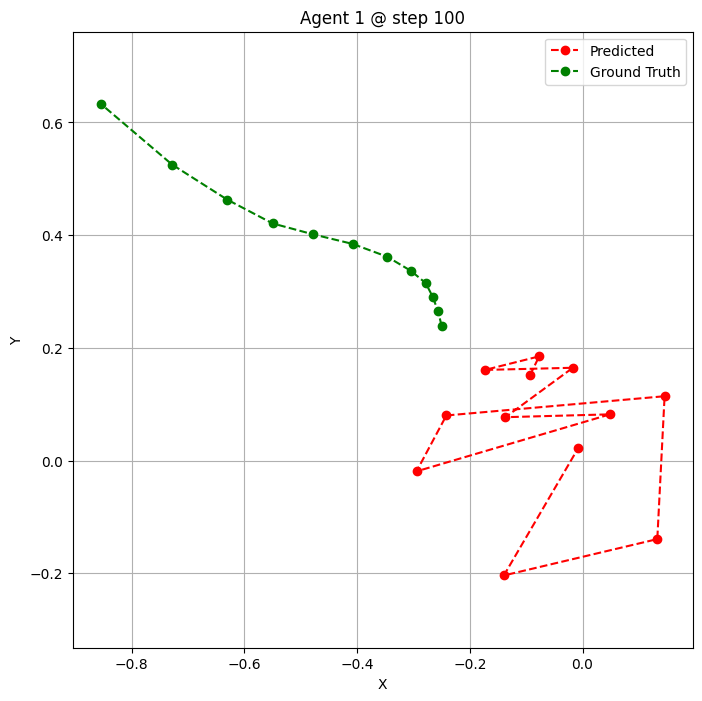

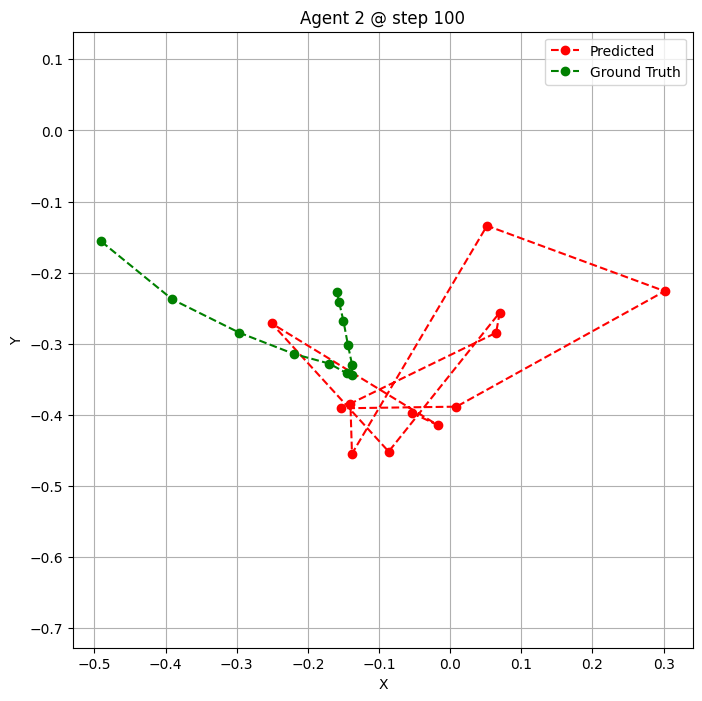

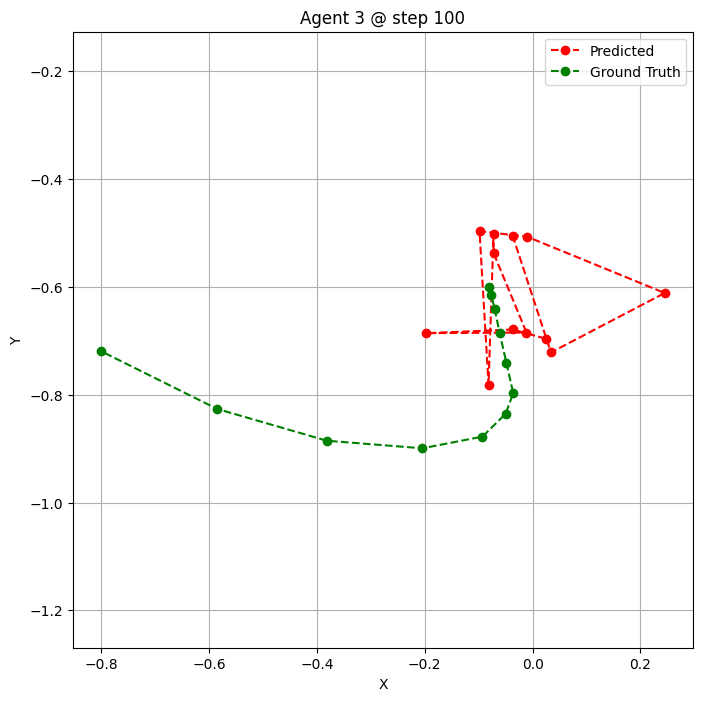

In [51]:
%env CUDA_LAUNCH_BLOCKING=1
%env TORCH_USE_CUDA_DSA=1
train()

In [45]:

print("seq_len" in TRM_ACT_NuScenes_Config.model_fields)


True
